In [1]:
import matplotlib.pyplot as plt
import jax, jax.numpy as jnp, jax.random as jr
from tqdm import trange
import pandas as pd
from cliff import Cliff
from util import Buf, get_episode_reward, fill_buffer
from ppo import expected_reward
from model import Embedding, EpsGreedy

key = jr.key(0)

CUDA backend failed to initialize: INTERNAL: no supported devices found for platform CUDA (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
env = Cliff()

In [3]:
action_tab = Embedding(24, 4)
eps_greedy = EpsGreedy(action_tab, 4, eps=.01)

In [4]:
# initialize model parameters
key, model_key = jr.split(key)
params_init = eps_greedy.init(model_key)
params, returns, entropies = params_init, [], []

# create trajectory buffer
buf = Buf(jnp.asarray(20), jnp.asarray(env.max_steps))
buf_state = buf.empty(buf_size=100)

In [5]:
for _ in (pbar := trange(400)):
    # generate trajectories
    buf_state = buf_state.reset() # reset buffer instead of always reallocating
    key, ep_key = jr.split(key)
    buf_state = fill_buffer(ep_key, eps_greedy, params, buf, buf_state, env)

    # compute gradients and update model using gradient ascent
    grads = jax.grad(expected_reward, argnums=1)(eps_greedy, params, buf_state)
    params = jax.tree_util.tree_map(lambda p, g: p + 1e-2 * g, params, grads)

    # bookkeeping
    log_probs = jax.nn.log_softmax(params)
    entropy = (-jnp.mean(log_probs * jnp.exp(log_probs))).item()
    entropies.append(entropy)
    num_eps = buf_state.num_eps.item()
    # compute average return for episodes
    avg_ret = (jnp.sum(get_episode_reward(buf_state)) / buf_state.num_eps).item()
    returns.append(avg_ret)
    pbar.set_description(f"{num_eps=:4d} {avg_ret=:6.01f} {entropy=:6.03f}")

num_eps=   6 avg_ret=  37.5 entropy= 0.134: 100%|██████████| 400/400 [00:19<00:00, 20.33it/s]


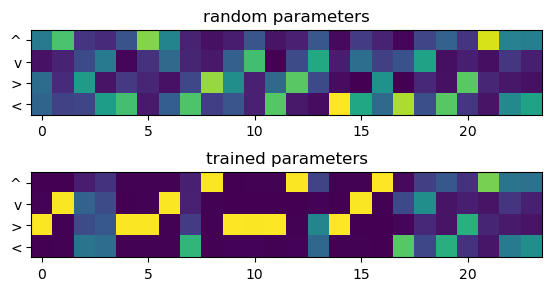

In [6]:
plt.figure(figsize=(8,3))
plt.subplot(2,1,1)
plt.title("random parameters")
plt.yticks(range(4), [*env.ACTION2CHAR.values()])
plt.imshow(jax.nn.softmax(params_init).T)
plt.subplot(2,1,2)
plt.title("trained parameters")
plt.yticks(range(4), [*env.ACTION2CHAR.values()])
plt.imshow(jax.nn.softmax(params).T)
plt.tight_layout();

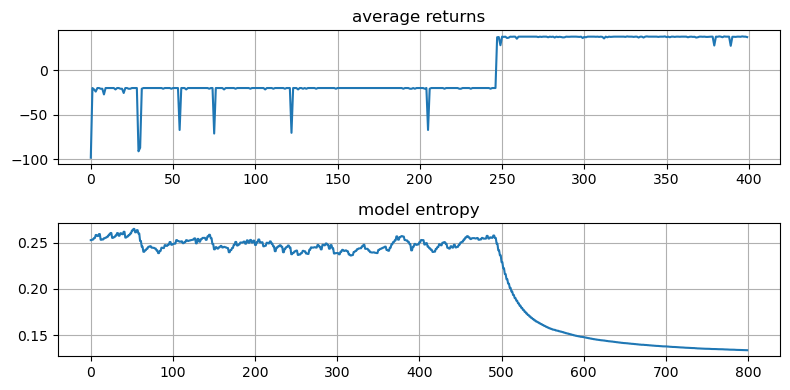

In [7]:
plt.figure(figsize=(8,4))
plt.subplot(2,1,1)
pd.Series(returns).plot.line(ax=plt.gca(), title="average returns", grid=True)
plt.subplot(2,1,2)
pd.Series(entropies).plot.line(ax=plt.gca(), title="model entropy", grid=True)
plt.tight_layout();